In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pickle
import sys, os, time

sys.path.append(os.path.abspath("src"))
from slp_model_setup import SegLabel, SLP_Model

In [2]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit.algorithms import VQE

from qiskit import Aer, transpile
from qiskit.utils import algorithm_globals, QuantumInstance

## Model

In [3]:
with open("data/hip-dataset.pickle", "rb") as f:
    segLabel = pickle.load(f)

num_nodes = segLabel.num_detections
num_labels = segLabel.num_classes
num_segments = 2  # segLabel.max_num_persons

# alpha_dc
A = segLabel.alphas.copy()
A[A > 100] = 100
# print(A)

# beta_dc_d'c'
B = segLabel.betas.copy()
# B = np.nan_to_num(B, nan=0.0)
# print(B)

model = SLP_Model(num_nodes, num_segments, num_labels, A, B)

In [4]:
# Build the DOcplex model of the S&L problem
mdl = model.build_model(D=100)
mdl.solve()
mdl.print_information()
mdl.print_solution()

x = np.zeros(mdl.number_of_binary_variables)
for v in mdl.iter_binary_vars():
    x[v.index] = v.solution_value
# print(x)

obj_exact = mdl.objective_value
x_exact = x

Model: Segmentation and Labeling
 - number of variables: 16
   - binary=16, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
objective: -2.200
status: OPTIMAL_SOLUTION(2)
  x_0_0_0=1
  x_1_0_1=1
  x_2_1_0=1
  x_3_1_1=1


## QAOA

In [5]:
mdl_qp = from_docplex_mp(mdl)
# print(mdl_qp.prettyprint())

mdl_qubo = QuadraticProgramToQubo().convert(mdl_qp)

qubitOp, offset = mdl_qubo.to_ising()

if True:
    # normalize the Hamiltonian
    w_max = np.max(np.abs(qubitOp.primitive.coeffs))
    qubitOp.primitive.coeffs /= w_max
    offset /= w_max

print("Offset:", offset)
# print("Ising Hamiltonian:\n", str(qubitOp))

Offset: 7.760113076590407


In [6]:
# QUBO matrix info
q2 = mdl_qubo.objective.quadratic.to_dict()
num_qubits = qubitOp.num_qubits
num_q2 = len(q2) - num_qubits
print("Number of quadratic terms: ", num_q2)
print("QUBO matrix sparsity: ", num_q2 / (num_qubits * (num_qubits - 1) * 0.5))

Number of quadratic terms:  72
QUBO matrix sparsity:  0.6


## Standard QAOA ansatz

In [7]:
from xy_mixer import xy_mixer_initial_state, xy_mixer

num_qubits = qubitOp.num_qubits
reps = 1

# XY mixer initialization
initial_state = xy_mixer_initial_state(num_qubits, num_nodes, num_labels * num_segments)

# XY mixer
mixer = xy_mixer(num_qubits, num_nodes, num_labels)

# QAOA ansatz
qc = QAOAAnsatz(qubitOp, reps=reps, initial_state=initial_state, mixer_operator=mixer)

In [8]:
n_shots = 100

seed = 12345
algorithm_globals.random_seed = seed
backend = Aer.get_backend("qasm_simulator")

quantum_instance = QuantumInstance(
    backend, seed_simulator=seed, seed_transpiler=seed, shots=n_shots
)

qc_tr = transpile(qc, backend=backend)
print("Depth: ", qc_tr.depth())

vqe = VQE(
    ansatz=qc,
    quantum_instance=quantum_instance,
)
vqe.optimizer._options["maxiter"] = 0

Depth:  32


### Surface plot

In [9]:
N1 = 20
N2 = 20
betas = np.linspace(start=-np.pi / 2, stop=np.pi / 2, num=N1)
gammas = np.linspace(start=-np.pi / 2, stop=np.pi / 2, num=N2)

energy = np.zeros((N1, N2))
for i, b in enumerate(betas):
    for j, g in enumerate(gammas):
        vqe.initial_point = [b, g]
        out = vqe.compute_minimum_eigenvalue(qubitOp)
        energy[i, j] = out.eigenvalue.real + offset

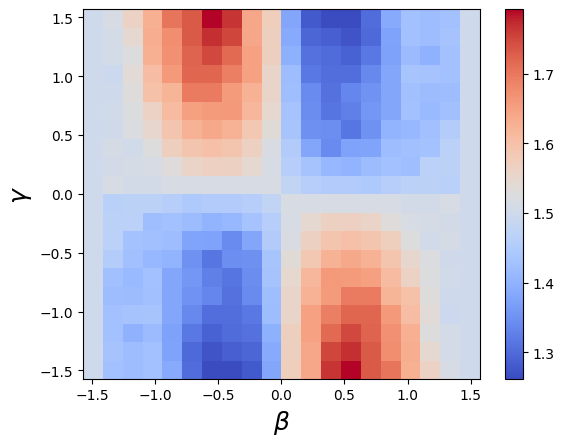

In [10]:
fig, ax = plt.subplots()
im = ax.imshow(
    energy.T,
    interpolation=None,
    origin="lower",
    extent=[betas.min(), betas.max(), gammas.min(), gammas.max()],
    vmax=None,
    aspect="auto",
    cmap="coolwarm",
)
fig.colorbar(im)

ax.set_xlabel(r"$\beta$", fontsize=18)
ax.set_ylabel(r"$\gamma$", fontsize=18)
plt.show()

## Rearranged QAOA ansatz

In [11]:
def find(s, ch):
    return tuple(i for i, ltr in enumerate(s) if ltr == ch)


op_list = qubitOp.primitive.to_list()

H_dict = dict()
for op in op_list:
    k = find(op[0], "Z")
    H_dict[k] = op[1]

ops = []
for p in range(reps):
    permutations = np.arange(num_qubits)  # To decrease the depth of the circuit
    for qbits, value in H_dict.items():
        s = ["I"] * num_qubits
        if len(qbits) == 1:
            s[qbits[0]] = "Z"
            ops.append(("".join(s), value))
    for jj in range(num_qubits):
        starting_qubit = jj % 2
        for k in range(starting_qubit, num_qubits - 1, 2):
            qubit_pair = (permutations[k], permutations[k + 1])
            if qubit_pair in H_dict.keys():
                s = ["I"] * num_qubits
                s[qubit_pair[0]] = "Z"
                s[qubit_pair[1]] = "Z"
                ops.append(("".join(s), H_dict[qubit_pair]))
            elif qubit_pair[::-1] in H_dict.keys():
                qubit_pair = qubit_pair[::-1]
                s[qubit_pair[0]] = "Z"
                s[qubit_pair[1]] = "Z"
                ops.append(("".join(s), H_dict[qubit_pair]))
            permutations[[k, k + 1]] = permutations[[k + 1, k]]

qubitOp_1 = qubitOp.from_list(ops)
qc_1 = QAOAAnsatz(qubitOp_1, reps=reps, initial_state=initial_state, mixer_operator=mixer)

qc_1_tr = transpile(qc_1, backend=backend)
print("Depth: ", qc_1_tr.depth())

Depth:  32


In [12]:
n_shots = 100

seed = 12345
algorithm_globals.random_seed = seed
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(
    backend, seed_simulator=seed, seed_transpiler=seed, shots=n_shots
)

vqe = VQE(
    ansatz=qc_1,
    quantum_instance=quantum_instance,
)
vqe.optimizer._options["maxiter"] = 0

### Surface plot

In [13]:
N1 = 20
N2 = 20

betas = np.linspace(start=-np.pi / 2, stop=np.pi / 2, num=N1)
gammas = np.linspace(start=-np.pi / 2, stop=np.pi / 2, num=N2)

energy = np.zeros((N1, N2))
for i, b in enumerate(betas):
    for j, g in enumerate(gammas):
        vqe.initial_point = [b, g]
        out = vqe.compute_minimum_eigenvalue(qubitOp)
        energy[i, j] = out.eigenvalue.real + offset

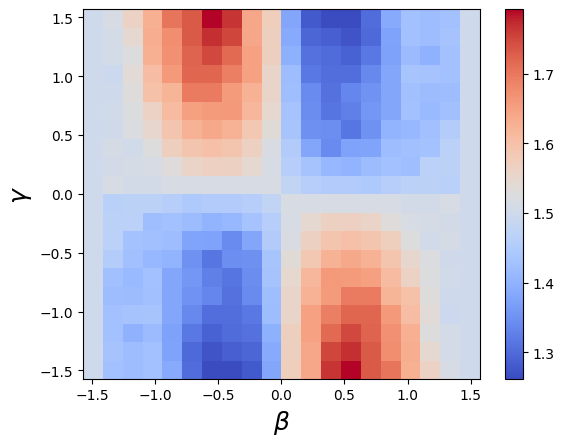

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(
    energy.T,
    interpolation=None,
    origin="lower",
    extent=[betas.min(), betas.max(), gammas.min(), gammas.max()],
    vmax=None,
    aspect="auto",
    cmap="coolwarm",
)
fig.colorbar(im)

ax.set_xlabel(r"$\beta$", fontsize=18)
ax.set_ylabel(r"$\gamma$", fontsize=18)
plt.show()